# Линейная классификация

Рассмотрим в работе способы построения линейной модели классификации.

Линейный классификатор представляет собой линейную модель, разделяющую два класса (-1, 1). Линейная модель описывается следующей формулой $\langle \omega, x \rangle + b = y$. Вектор весов $\omega$ - вектор нормали этой линейно модели. При $y = 0$, все точки $x$ принадлежат этой разделяющей прямой, при $y > 0$ объеты $x$ лежат с той стороны прямой линии, куда смотрит вектор весов $\omega$, при $y < 0$ с другой стороны прямой линии. Таким образом линейная модель разделяет все объекты на положительный и отрицательные, причем чем дальше объект лежит от прямой, тем большее абсолютное значение он имеет.

Необходимо ввести обозначение отступа:

$$M = y \langle \omega, x \rangle$$

Таким образом, если объект будет лежать со стороны своего класса (классифицироваться правильно), то $M$ всегда будет иметь положительное значение. В случае неправилной классификации отступ будет отрицательным.

Введем несколько loss-функцию, которые будет оптимизировать:

1. логистическая: $$\bar L(M) = \ln(1+ \exp(-M))$$

2. экспоненциальны: $$\bar L(M) = \exp(-M)$$

3. кусочно-линейная: $$\bar L(M) = max(0, 1-M))$$

Таким образом для каждого объекта будет вычислена его собственный штраф. Чтобы получить полную функцию потеря - просто проссумируем штрафы всех объектов.
Таким образом у нас будет функция, подсчитывающая штрафы для конкретной модели. Необходимо ее оптимизировать, для этого надо вычислить градиент и начать движение (изменение весов модели $\omega$) в сторону антиградиента с некоторым постоянным шагом.

## Задача
1. Написать функцию расчета функции потерь (loss-функции) и градиента функции. (выбрать любую функцию)
2. Реализовать градиентный спуск по всем данным.
3. Реализовать стохастический градиентный спуск.

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Задача 1
Напишите две функции, которые будут получать на вход вектор весов, признаки и целевую переменную. Функции должны возвращать суммарную ошибку и градиент.

In [57]:
def loss(c_w0, c_w1, c_w2, x, y):
    w = np.array((c_w0,c_w1, c_w2))  
    t = np.hstack((x,np.ones((x.shape[0],1))))
    loss = 0
    for i in range(x.shape[0]):
        M = np.multiply(np.dot(w, t[i]),y[i])
        loss += np.log(1+np.exp(-M))
    return loss

def grad_loss(c_w0, c_w1, c_w2, x, y):    
    sigma = 1e-2
    tmp = np.array((step(c_w0,sigma),step(c_w1,sigma),step(c_w2,sigma)))    
    dw0 = (loss(tmp[0][1],c_w1,c_w2,x,y)-loss(tmp[0][0],c_w1,c_w2,x,y))/(tmp[0][1]-tmp[0][0])
    dw1 = (loss(tmp[1][1],c_w1,c_w2,x,y)-loss(tmp[1][0],c_w1,c_w2,x,y))/(tmp[1][1]-tmp[1][0])
    dw2 = (loss(tmp[2][1],c_w1,c_w2,x,y)-loss(tmp[2][0],c_w1,c_w2,x,y))/(tmp[2][1]-tmp[2][0])
    return dw0,dw1,dw2

def step(w,sigma):
    return (w-sigma,w+sigma)

Дан набор данных.
Проведена нормализация данных по признакам и выставлены классы (-1, 1).

Проведите случайную линейную модель, постройте ее на графике и вычислите для нее суммарную функцию ошибки.
Проверьте, что суммарная функция ошибки считается правильно.

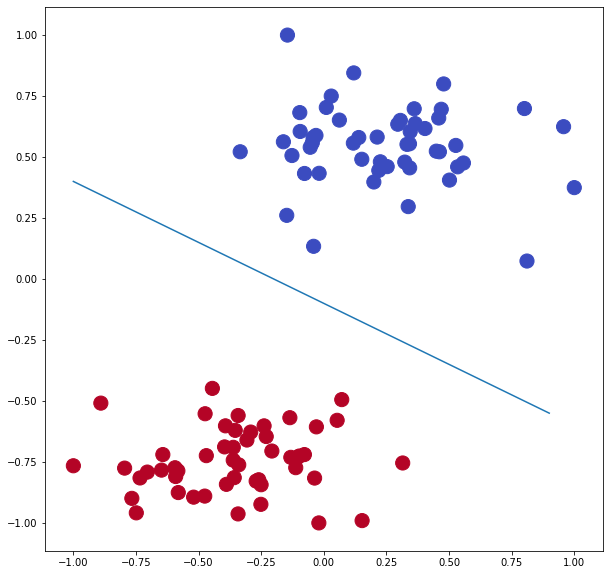

In [16]:
X, Y = make_blobs(n_samples=100, n_features=2, centers=2 ,cluster_std=1, random_state=17, center_box=(-10, 10))
cmap = plt.cm.coolwarm
plt.figure(figsize=(10,10))
X[:,0] = 2 * (X[:,0] - X[:,0].min()) / (X[:,0].max() - X[:,0].min()) - 1
X[:,1] = 2 * (X[:,1] - X[:,1].min()) / (X[:,1].max() - X[:,1].min()) -1 
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)
x = np.arange(-1, 1, 0.1)
w0 = 0.1
w1 = 0.5
w2 = 1
y = (-w1 * x - w0) / w2
plt.plot(x, y)
Y[Y == 0] = -1

In [23]:
print(loss(w0, w1, w2, X, Y))

134.7773990950586


### Задача 2. Реализация метода градиентного спуска
Постройте анимационную гифку схождения вашей линейной модели к данным. Подпишите loss к каждому кадру на гифке.

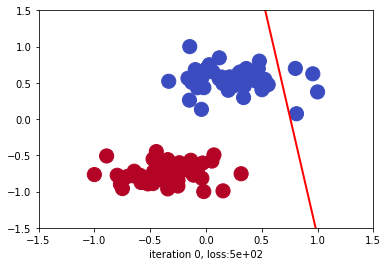

In [54]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()

k = 10
b = -5
m = 1e-3 # шаг обучения

# Данные
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)

# Модель данных
line = lambda x1 : -(x1 * k + b)
clf, = ax.plot([X[:,0].min() - .5, X[:,0].max() + .5], [line(X[:,0].min() - .5), line(X[:,0].max() + .5)], 'r-', linewidth=2)

# Настройка графика
ax.set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax.set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])


def update(i):
    global w, X, Y, m, k, b
    label = 'iteration {0}, loss:{1:.2}'.format(i, loss(b,k,1,X,Y))
    
    # Градиент в примере задан постоянными величинами
    # На деле после каждой итерации необходимо пересчитывать градиент и изменять веса модели.
    div_w0,div_w1,_ = grad_loss(b, k, 1, X, Y)   
    
    k -= m * div_w0
    b -= m * div_w1


    line = lambda c_x : -(c_x * k + b)
    clf.set_ydata([line(X[:,0].min()), line(X[:,0].max())])
    ax.set_xlabel(label)
    return line, ax

anim = FuncAnimation(fig, update, frames=np.arange(0, 100))
rc('animation', html='html5')

In [55]:
anim

### Задача 3. Реализация стохастического градиентного спуска.
Используйте на каждой итерации не весь набор данных, а $n$ случайных объектов из выборки. Оформите результат схождения вашей модели в виде гифки.

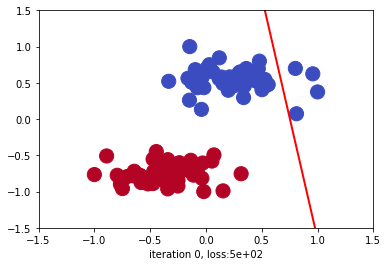

In [27]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import animation, rc

fig, ax = plt.subplots()

k = 10
b = -5
m = 1e-3 # шаг обучения
n = 50

# Данные
plt.scatter(X[:,0], X[:,1], s = 200, c = Y, cmap=cmap)

# Модель данных
line = lambda x1 : -(x1 * k + b)
clf, = ax.plot([X[:,0].min() - .5, X[:,0].max() + .5], [line(X[:,0].min() - .5), line(X[:,0].max() + .5)], 'r-', linewidth=2)

# Настройка графика
ax.set_xlim([X[:,0].min() - .5, X[:,0].max() + .5])
ax.set_ylim([X[:,1].min() - .5, X[:,1].max() + .5])


def update(i):
    global w, X, Y, m, k, b
    label = 'iteration {0}, loss:{1:.2}'.format(i, loss(b,k,1,X,Y))
    
    # Градиент в примере задан постоянными величинами
    # На деле после каждой итерации необходимо пересчитывать градиент и изменять веса модели.    
    index = np.random.choice(range(X.shape[0]),n)
    x = np.copy(X[index])
    y = np.copy(Y[index])
    div_w0,div_w1,_ = grad_loss(b, k, 1, x, y)   
    
    k -= m * div_w0
    b -= m * div_w1


    line = lambda c_x : -(c_x * k + b)
    clf.set_ydata([line(X[:,0].min()), line(X[:,0].max())])
    ax.set_xlabel(label)
    return line, ax

anim = FuncAnimation(fig, update, frames=np.arange(0, 100))
rc('animation', html='html5')

In [28]:
anim